DATASET: https://physionet.org/content/butqdb/1.0.0/#files-panel

In [1]:
# import some libraries
import numpy as np
import pandas as pd
from google.colab import drive
from scipy.signal import resample, butter, filtfilt, iirnotch
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
import gc
import csv

In [2]:
# download library WFDB to manage dataset
!pip install wfdb
import wfdb
from wfdb import processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.3 MB/s eta 0:00:00


In [3]:
drive.mount('/content/drive', force_remount=True)
but_qdb_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/datasets/BUT-QDB-1.0.0"
dataset_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/preprocessing/dataset.csv"
processed_dataset_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/preprocessing/dataset_processed.csv"

Mounted at /content/drive


In [4]:
def remove_not_annotated(annotator):

    # remove rows where annotation label == 0
    #annotator.drop(annotator[annotator['ann'] == 0].index, inplace = True)
    annotator = annotator[annotator['ann'] != 0]

    # Drop the rows where at least one element is missing.
    annotator = annotator.dropna()

    return annotator

def process_ecg_files(dataset_path):

    with os.scandir(dataset_path) as dirs_files:
      # Cicle for each directory (1 patient <-> 1 directory)
      for patient in dirs_files:
          if patient.is_dir():
            patient_path = dataset_path + '/' + patient.name
            ecg_file = patient_path + '/' + patient.name + "_ECG"
            # Usa un generatore per leggere e processare i file uno alla volta in RAM
            yield wfdb.rdrecord(ecg_file).p_signal

def process_ann_files(dataset_path):
    # annotations CSV
    col_names = ['start1', 'end1', 'ann1', 'start2', 'end2', 'ann2', 'start3', 'end3', 'ann3', 'start', 'end', 'ann']

    with os.scandir(dataset_path) as dirs_files:
      # Cicle for each directory (1 patient <-> 1 directory)
      for patient in dirs_files:
          if patient.is_dir():
            # Usa un generatore per leggere e processare i file uno alla volta in RAM
            # take only consensus columns
            patient_path = dataset_path + '/' + patient.name
            ann_file = patient_path + '/' + patient.name + "_ANN.csv"
            # return as a generator the consensus part of the annotation dataframe
            yield remove_not_annotated(pd.read_csv(ann_file, names=col_names, header=None)[['start', 'end', 'ann']])

def process_patients(dataset_path):

    with os.scandir(dataset_path) as dirs_files:
          # Cicle for each directory (1 patient <-> 1 directory)
          for patient in dirs_files:
              if patient.is_dir():
                yield patient.name

In [5]:
# test for annotations' generator
def plot_first_annotation(dataset_path):
  for annotator in process_ann_files(dataset_path):
    print(annotator[['ann']].value_counts())
    # Processa le annotazioni
    print(annotator)
    break

plot_first_annotation(but_qdb_path)

ann
2.0    382
1.0    379
3.0      2
Name: count, dtype: int64
          start         end  ann
0           1.0      7047.0  2.0
1        7048.0     17209.0  1.0
2       17210.0     28694.0  2.0
3       28695.0     32653.0  1.0
4       32654.0    112474.0  2.0
..          ...         ...  ...
758  86486096.0  86580752.0  2.0
759  86580753.0  86588415.0  1.0
760  86588416.0  86757975.0  2.0
761  86757976.0  86827127.0  1.0
762  86827128.0  87087000.0  2.0

[763 rows x 3 columns]


In [6]:
# procedure to extract samples from a single patient
def extract_samples_from_patient(patient, ecg_signal, start_ann, end_ann, labels_ann, step_size, index, n_rows):

    # np array to save values
    stacked_samples = np.zeros((1, step_size + 1))

    for start, end, ann in tqdm(zip(start_ann, end_ann, labels_ann), total = n_rows, desc=' (' + str(index+1) + '/18) Processing patient - ' + patient):

        # renaming ECG segment and time
        segment = ecg_signal[int(start) : int(end)].flatten()
        #time_segment = time_ecg[int(start) : int(end)]

        # Utilizzare un ciclo for con range e passo per scorrere il segmento
        for window_start in range(0, len(segment), step_size):

            # end window index
            window_end = window_start + step_size
            # discard portion of the signal with insufficient length
            if window_end > len(segment):
              # exit inner for loop
              break
            else:
              # sample to save
              ecg_sample = segment[window_start : window_end].flatten()

              #  add class labels as last element
              if ann == 1:
                # horizontal stack numpy array
                ecg_sample = np.hstack((ecg_sample, np.ones((1))))     # class 1
              elif ann == 2:
                ecg_sample = np.hstack((ecg_sample, np.ones((1)) * 2)) # class 2
              elif ann == 3:
                ecg_sample = np.hstack((ecg_sample, np.ones((1)) * 3)) # class 3
              else:
                raise Exception('ERROR: quality signal not recognised!')

              # add current sample + label into the matrix of all current samples
              # vertical stack numpy array
              stacked_samples = np.vstack((stacked_samples, ecg_sample))

    print('Saving Dataset... ', end='')
    # save dataset to CSV format to free RAM memory
    path = '/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/preprocessing/'

    if index == 0:
      # WRITE MODE (NOT APPEND FIRST LOOP)
      csv_file = open(path + 'dataset.csv', 'w')
    else:
      # APPEND MODE
      csv_file = open(path + 'dataset.csv', 'a')

    # create pandas dataframe from numpy - range from 0 to step_size + 1
    # column n. step_size + 1 is CLASS LABEL (like MIT-BIH dataset)
    # NOTA: stacked_samples[0] == np.zeros(...)
    dataset_df = pd.DataFrame(stacked_samples[1:], columns=pd.RangeIndex(0, step_size + 1))

    # save the dataset dataframe and free RAM memory occupied by dataset_df
    if index == 0:
      dataset_df.to_csv(path_or_buf=csv_file, index=False)
    else:
      # NNB non includere l'header!
      dataset_df.to_csv(path_or_buf=csv_file, mode='a', index=False, header=False)

    # close csv_file
    csv_file.close()

    # free RAM memory
    try:
      del dataset_df
      del stacked_samples
      del ecg_sample
      del ecg_signal
    except:
      pass
    finally:
      gc.collect()

    print('done!')

In [7]:
# numbers to class mapping
labels_map ={1 : 'Eccellent Quality', 2 : 'Medium Quality', 3 : 'Bad Quality', 0 : 'Not annotated'}

# sampling frequencies -> 1000 Hz (SAME FOR ALL)
ecg_sf = 1000

################################################################################
# WINDOW SIZE FOR SIGNAL CROPPING
step_size = 10*ecg_sf # 10 sec
################################################################################

In [8]:
############################### DATA INTENSIVE ################################

def dataset_windowing(dataset_path, step_size):
  # creo dei generatori per non saturare la memoria RAM
  signal_generator = process_ecg_files(dataset_path)
  ann_generator = process_ann_files(dataset_path)
  patients_generator = process_patients(dataset_path)

  for index, (ecg_signal, annotator, patient) in enumerate(zip(signal_generator, ann_generator, patients_generator)):

      # time for all the recording
      #time_ecg = np.arange(0, len(ecg_signal)) / ecg_sf

      ############################################################ DATA INTENSIVE
      # change this to take only a part of the data
      n_rows = len(annotator['ann'])

      start_ann = annotator['start'].iloc[: n_rows]
      end_ann = annotator['end'].iloc[: n_rows]
      labels_ann = annotator['ann'].iloc[: n_rows]
      ############################################################

      # extract samples from a single patient and save all in a single CSV file
      extract_samples_from_patient(patient, ecg_signal, start_ann, end_ann, labels_ann, step_size, index, n_rows)

  print('>>> All done !!!')

dataset_windowing(but_qdb_path, step_size)

 (1/18) Processing patient - 100001: 100%|██████████| 763/763 [18:10<00:00,  1.43s/it]


Saving Dataset... done!


 (2/18) Processing patient - 100002: 100%|██████████| 229/229 [00:00<00:00, 456.36it/s] 


Saving Dataset... done!


 (3/18) Processing patient - 103001: 100%|██████████| 183/183 [00:00<00:00, 565.89it/s]


Saving Dataset... done!


 (4/18) Processing patient - 103002: 100%|██████████| 110/110 [00:00<00:00, 214.85it/s]


Saving Dataset... done!


 (5/18) Processing patient - 103003: 100%|██████████| 174/174 [00:00<00:00, 301.39it/s]


Saving Dataset... done!


 (6/18) Processing patient - 104001: 100%|██████████| 104/104 [00:00<00:00, 233.24it/s]


Saving Dataset... done!


 (7/18) Processing patient - 105001: 100%|██████████| 1354/1354 [47:27<00:00,  2.10s/it]


Saving Dataset... done!


 (8/18) Processing patient - 111001: 100%|██████████| 2739/2739 [17:51<00:00,  2.56it/s]


Saving Dataset... done!


 (9/18) Processing patient - 113001: 100%|██████████| 213/213 [00:01<00:00, 108.00it/s]


Saving Dataset... done!


 (10/18) Processing patient - 114001: 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Saving Dataset... done!


 (11/18) Processing patient - 115001: 100%|██████████| 147/147 [00:00<00:00, 226.32it/s]


Saving Dataset... done!


 (12/18) Processing patient - 118001: 100%|██████████| 122/122 [00:00<00:00, 208.74it/s]


Saving Dataset... done!


 (13/18) Processing patient - 121001: 100%|██████████| 170/170 [00:00<00:00, 441.77it/s]


Saving Dataset... done!


 (14/18) Processing patient - 122001: 100%|██████████| 25/25 [00:00<00:00, 32.98it/s]


Saving Dataset... done!


 (15/18) Processing patient - 123001: 100%|██████████| 112/112 [00:00<00:00, 316.88it/s]


Saving Dataset... done!


 (16/18) Processing patient - 124001: 100%|██████████| 542/542 [00:00<00:00, 753.46it/s]


Saving Dataset... done!


 (17/18) Processing patient - 125001: 100%|██████████| 37/37 [00:00<00:00, 79.23it/s] 


Saving Dataset... done!


 (18/18) Processing patient - 126001: 100%|██████████| 58/58 [00:00<00:00, 132.91it/s]


Saving Dataset... done!
>>> All done !!!


In [9]:
# DA CARICARE CON:
df = pd.read_csv(dataset_path)
df

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,4300.100200,4266.032064,4243.987976,4225.951904,4210.921844,4222.945892,4237.975952,4240.981964,4230.961924,4235.971944,...,830.160321,837.174349,822.144289,819.138277,823.146293,824.148297,820.140281,825.150301,831.162325,1.0
1,832.164329,849.198397,843.186373,819.138277,828.156313,856.212425,850.200401,839.178357,841.182365,834.168337,...,307.114228,305.110220,306.112224,310.120240,306.112224,292.084168,256.012024,205.911824,185.871743,2.0
2,-79.158317,-97.194389,-130.761523,-152.805611,-132.765531,-101.202405,-77.154309,-57.114228,-39.078156,-44.088176,...,405.811623,404.809619,411.823647,417.835671,420.841683,419.839679,417.835671,418.837675,408.817635,2.0
3,387.775551,379.759519,380.761523,374.749499,365.230461,361.222445,354.208417,333.166333,298.096192,262.024048,...,1637.775551,1614.228457,1584.168337,1573.146293,1583.166333,1580.160321,1549.098196,1489.979960,1423.847695,2.0
4,1322.144289,1137.775551,914.829659,707.915832,522.044088,376.753507,261.022044,172.845691,111.222445,86.172345,...,-63.126253,47.094188,145.791583,267.034068,379.759519,461.923848,540.080160,629.759519,728.957916,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32951,12.000240,12.000240,6.000120,2.000040,0.000000,-3.000060,8.000160,15.000300,16.000320,17.000340,...,-43.000860,-36.000720,-34.000680,-36.000720,-39.000780,-38.000760,-39.000780,-36.000720,-34.000680,1.0
32952,-38.000760,-40.000800,-39.000780,-36.000720,-36.000720,-36.000720,-32.000640,-28.000560,-28.000560,-31.000620,...,-63.001260,-64.001280,-61.001220,-60.001200,-58.001160,-61.001220,-58.001160,-57.001140,-60.001200,1.0
32953,-14.000280,-25.000500,-28.000560,-25.000500,-29.000580,-29.000580,-35.000700,-46.000920,-51.001020,-56.001120,...,-32.000640,-32.000640,-32.000640,-35.000700,-34.000680,-25.000500,-23.000460,-23.000460,-20.000400,1.0
32954,-20.000400,-21.000420,-27.000540,-24.000480,-20.000400,-16.000320,-20.000400,-16.000320,-10.000200,-9.000180,...,-46.000920,-51.001020,-45.000900,-43.000860,-54.001080,-60.001200,-65.001300,-61.001220,-54.001080,1.0


In [10]:
def class_distribution(df):
  return df.iloc[:, -1].value_counts()

10000
1.0    17043
2.0    10628
3.0     5285
Name: count, dtype: int64


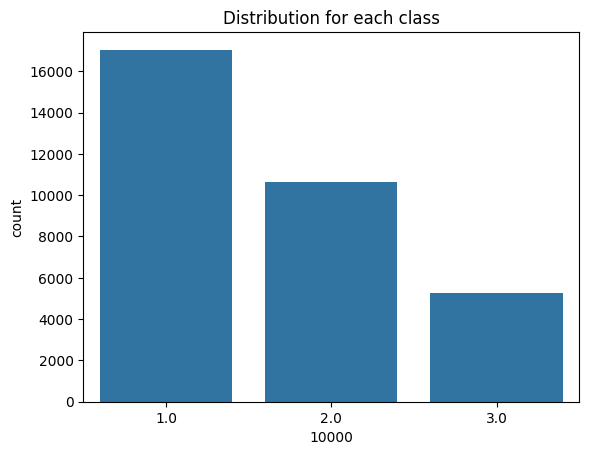

In [11]:
# distribution for each class
print(class_distribution(df))
# plot distributions for each class
num_columns = len(df.columns) - 1
sns.countplot(x=str(num_columns), data=df)
plt.title('Distribution for each class')
plt.show()

In [12]:
def plot_samples_from_df(df, start, end):

    num_rows = df.shape[0]

    assert start < end <= num_rows, "Invalid indices"

    samples =  df.iloc[start : end, : -1].values
    labels = df.iloc[start : end, -1].values

    for sample, label in zip(samples, labels):
        plt.title(labels_map[label])
        plt.plot(sample)
        plt.grid()
        plt.show()

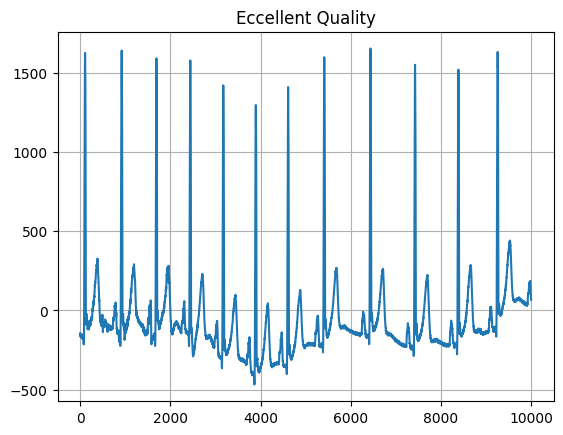

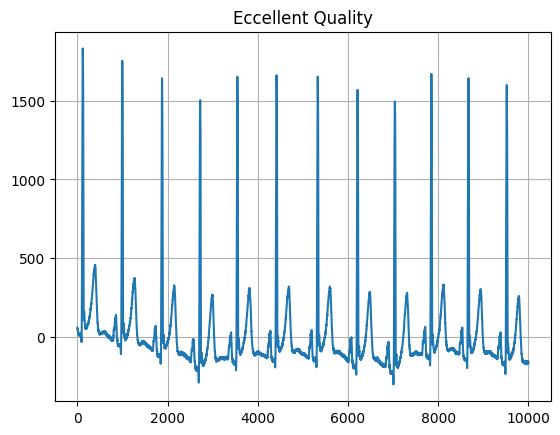

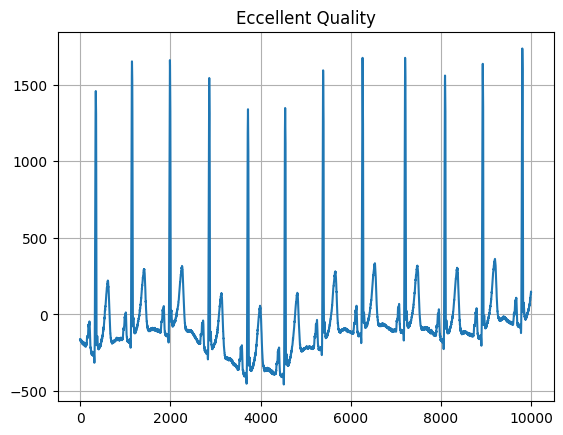

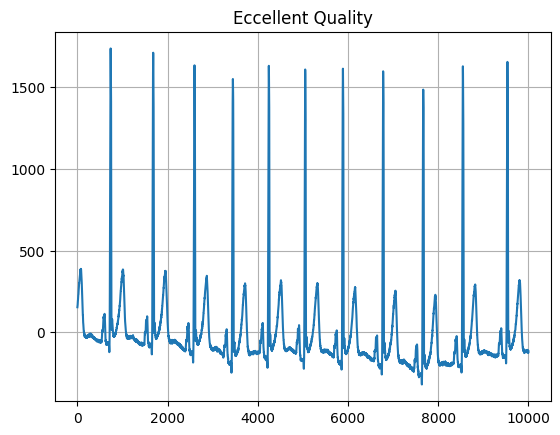

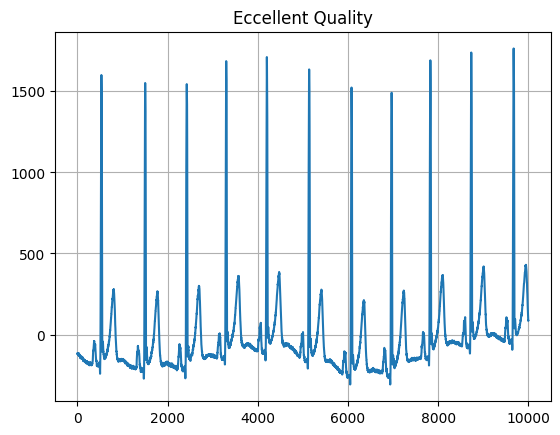

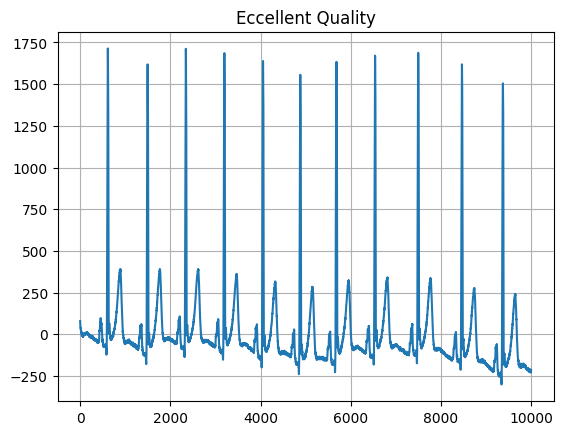

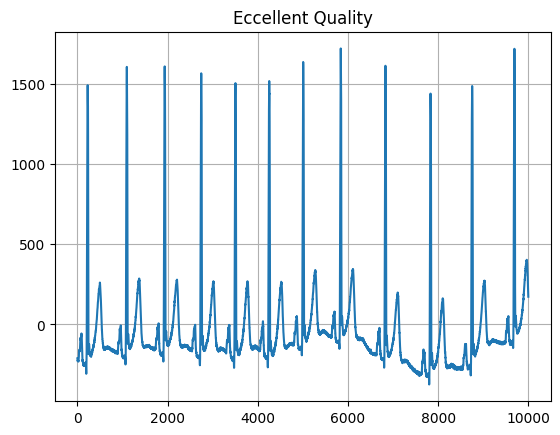

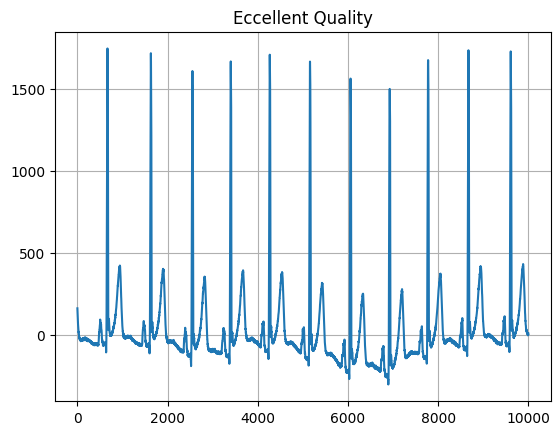

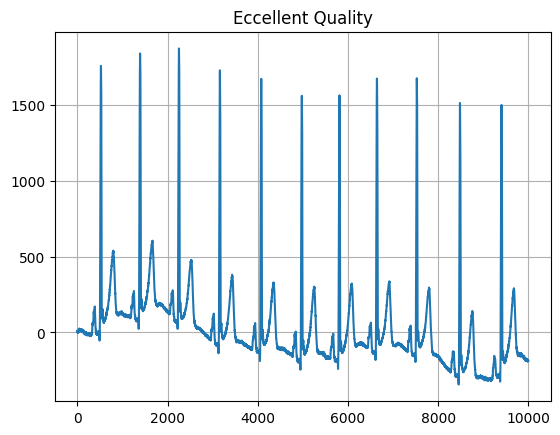

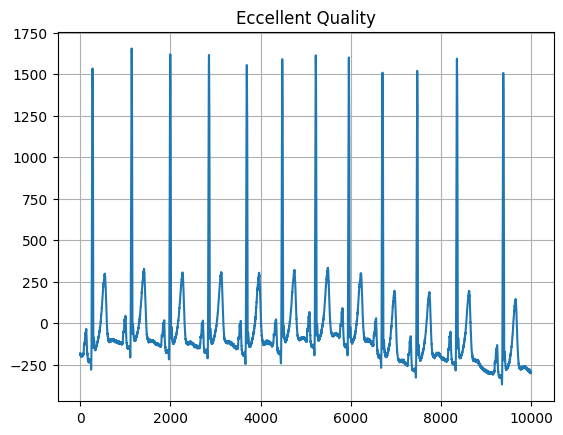

In [15]:
plot_samples_from_df(df, 1100, 1110)
#plot_samples_from_df(df, 100, 110)

In [16]:
# free RAM memory
del df
gc.collect()

36847

In [17]:
def process_df(dataset_path, skip_header=True):

    with open(dataset_path, "r") as csv1:

          reader = csv.reader(csv1)

          if skip_header:
            next(reader, None)

          for row in reader:
              yield np.array(row, dtype=np.float32)

In [18]:
def plot_first_n_samples(dataset_path, n):
  for idx, row in enumerate(process_df(dataset_path)):
    plt.plot(row[:-1])
    plt.title(str(labels_map[row[-1]]))
    plt.grid()
    plt.show()
    if idx+1 == n: break

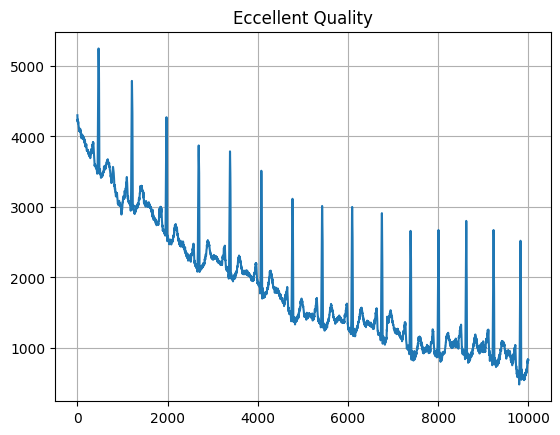

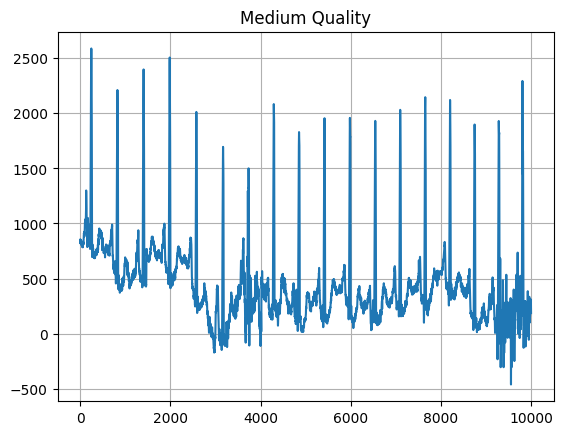

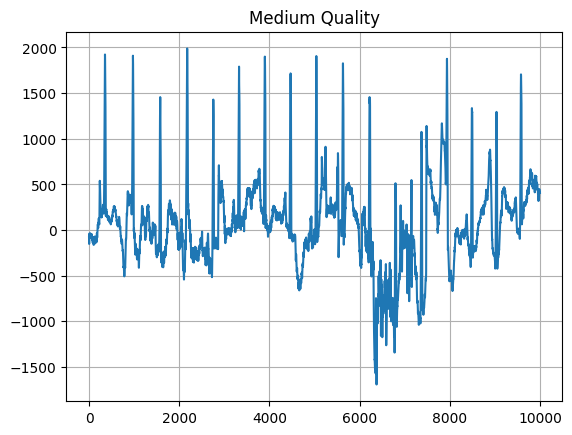

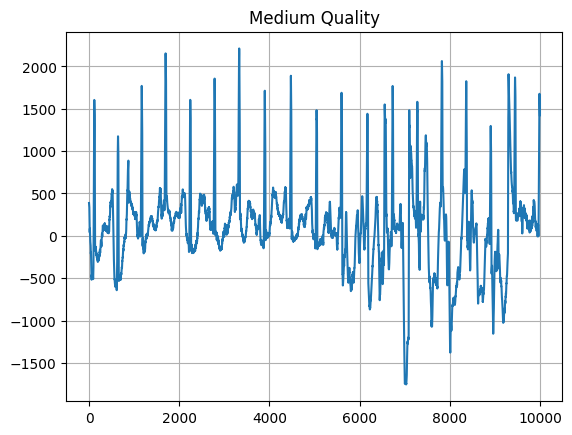

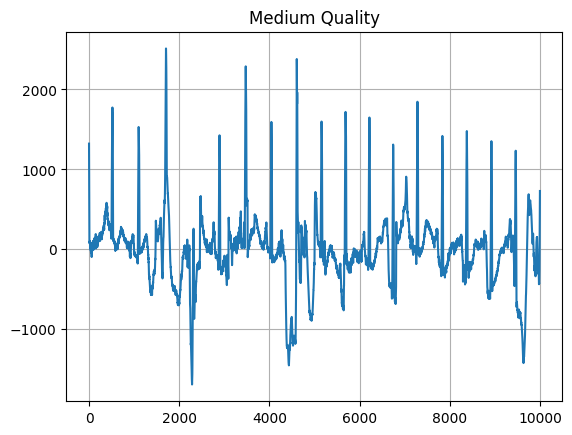

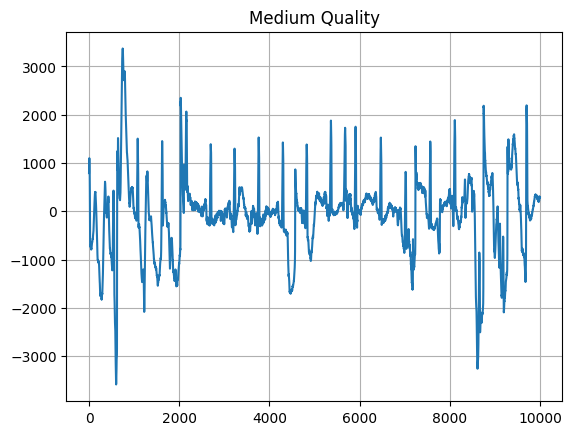

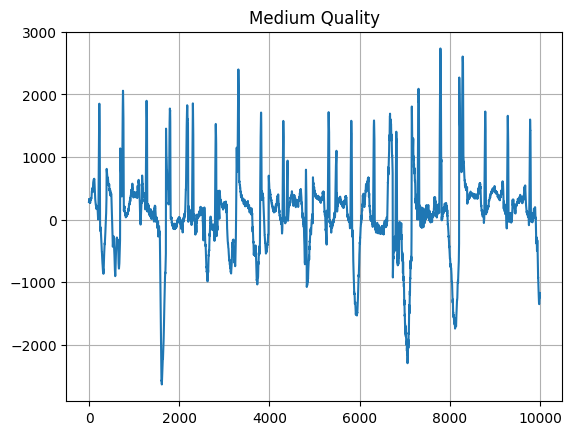

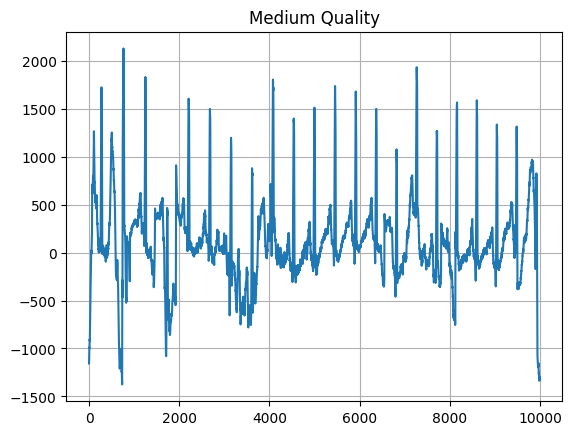

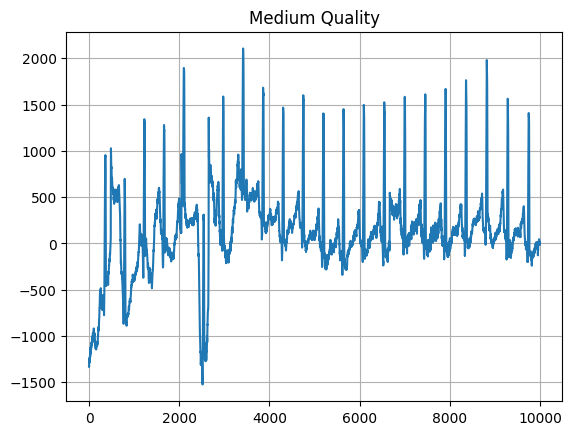

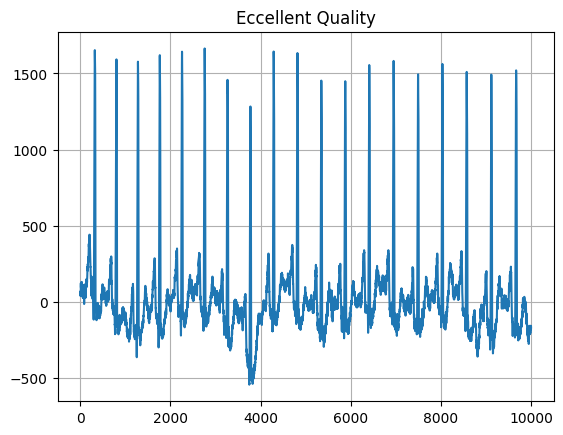

In [19]:
plot_first_n_samples(dataset_path, 10)

In [20]:
def preprocess_sample(signal, new_freq, original_sf=1000):
  # https://doi.org/10.3390/bdcc8060057
  # https://physionet.org/content/butqdb/1.0.0/

  #################
  # 1) DOWNSAMPLING
  #################

  num_samples = int(len(signal) * new_freq / original_sf)
  resampled_signal = resample(np.array(signal), num_samples)

  #########################################
  # 2) BUTTERWORTH HIGH-PASS FILTER 0.67 Hz
  #########################################

  # Ordine del filtro e frequenza di taglio
  order = 4
  cutoff = 0.67

  # Normalizzazione della frequenza di taglio
  nyquist = 0.5 * original_sf
  normal_cutoff = cutoff / nyquist

  # Coefficienti del filtro Butterworth
  b, a = butter(order, normal_cutoff, btype='high', analog=False)

  # Applicazione del filtro al segnale
  filtered_signal = filtfilt(b, a, resampled_signal)

  #######################
  # 3) NOTCH FILTER 50 Hz
  #######################

  f0 = 50.0  # Frequenza da filtrare (50 Hz)
  Q = 30.0   # Fattore di qualità (più alto è, più stretto è il notch)

  # Coefficienti del filtro notch
  b_notch, a_notch = iirnotch(f0 / nyquist, Q)

  # Applicazione del filtro notch al segnale
  final_filtered_signal = filtfilt(b_notch, a_notch, filtered_signal)

  ##########################
  # 4) MIN-MAX NORMALIZATION
  ##########################

  # Reshape per adattare il segnale all'input di MinMaxScaler (che si aspetta una matrice 2D)
  final_filtered_signal = final_filtered_signal.reshape(-1, 1)

  # Definiamo l'intervallo di normalizzazione
  scaler = MinMaxScaler(feature_range=(-1, 1))

  # Applichiamo la normalizzazione
  normalized_signal = scaler.fit_transform(final_filtered_signal)

  # Rimuoviamo la dimensione aggiuntiva per avere un array 1D
  normalized_signal = normalized_signal.flatten()

  return normalized_signal

In [21]:
# utility func
def preprocess_row(row, new_freq):
  row = row.to_numpy()
  # remove labels
  signal = row[:-1]
  preprocessed_signal = preprocess_sample(signal, new_freq)
  # add label after preprocessing
  preprocessed_row = np.hstack((preprocessed_signal, row[-1]))
  return pd.Series(preprocessed_row)

def processa_csv(input_file, output_file, new_freq, chunk_size=10000):
    # Leggi e processa il file in blocchi
    chunks = pd.read_csv(input_file, chunksize=chunk_size)

    # Scrivi ogni blocco processato in un nuovo file CSV
    for i, chunk in enumerate(chunks):
        chunk = chunk.astype(float).apply(lambda r: preprocess_row(r, new_freq), axis=1)

        # Se è il primo chunk, includi l'intestazione, altrimenti aggiungi solo i dati
        if i == 0:
            chunk.to_csv(output_file, index=False, mode='w')
        else:
            chunk.to_csv(output_file, index=False, header=False, mode='a')

In [22]:
input_file = '/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/preprocessing/dataset.csv'
output_file = '/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/preprocessing/dataset_processed.csv'

################################################
# RESAMPLE FREQUENCY
new_freq = 250
################################################

# process CSV
processa_csv(input_file, output_file, new_freq)

In [23]:
# PREPROCESSED DF:
df = pd.read_csv(processed_dataset_path)
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,-0.438138,0.618891,0.311601,0.470097,0.330869,0.444004,0.337303,0.404934,0.325823,0.382354,...,-0.553014,-0.506705,-0.553322,-0.456354,-0.523623,-0.421482,-0.530643,-0.333371,-0.628572,1.0
1,-0.551117,-0.329635,-0.397577,-0.373191,-0.399101,-0.391066,-0.403648,-0.389575,-0.387534,-0.373725,...,-0.642803,-0.592077,-0.577079,-0.602867,-0.591623,-0.510817,-0.540661,-0.476087,-0.568999,2.0
2,-0.108788,-0.259244,-0.182802,-0.220931,-0.203066,-0.227950,-0.202632,-0.215205,-0.212058,-0.215222,...,-0.117645,-0.144758,-0.129717,-0.147656,-0.123460,-0.111011,-0.108106,-0.137789,-0.087755,2.0
3,-0.139145,-0.334940,-0.303401,-0.400829,-0.413991,-0.424679,-0.443348,-0.485302,-0.483783,-0.512934,...,-1.000000,-0.991821,-0.885317,-0.741884,-0.575676,-0.470824,-0.379897,-0.443199,-0.432753,2.0
4,-0.274404,-0.480679,-0.732988,-0.717777,-0.731522,-0.712511,-0.737910,-0.741917,-0.757853,-0.776206,...,-0.596551,-0.592740,-0.609229,-0.661037,-0.695323,-0.684173,-0.652609,-0.473698,-0.302491,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32951,0.100446,0.117015,0.121247,0.142377,0.141766,0.147383,0.151664,0.157520,0.156751,0.153292,...,-0.495954,-0.515633,-0.531056,-0.553070,-0.565477,-0.573951,-0.577206,-0.567234,-0.558436,1.0
32952,-0.116962,-0.101911,-0.093453,-0.086774,-0.076941,-0.068891,-0.063290,-0.052928,-0.049481,-0.045876,...,-0.173669,-0.162429,-0.153022,-0.139698,-0.122872,-0.108316,-0.093808,-0.082545,-0.076810,1.0
32953,-0.177759,-0.183084,-0.206478,-0.227821,-0.263806,-0.316868,-0.272228,-0.095946,0.087111,0.330160,...,-0.149319,-0.164652,-0.177347,-0.195834,-0.205244,-0.214755,-0.215130,-0.214387,-0.202264,1.0
32954,-0.043413,-0.034304,-0.033921,-0.028183,-0.034511,-0.026424,-0.018008,-0.007777,-0.001952,0.008577,...,-0.161284,-0.168484,-0.168377,-0.162559,-0.156203,-0.147757,-0.132384,-0.103830,-0.101764,1.0


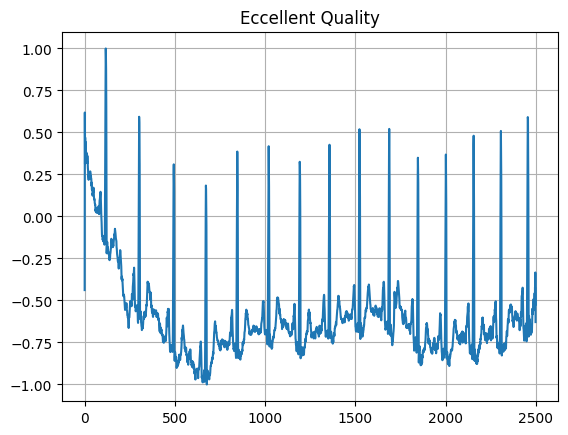

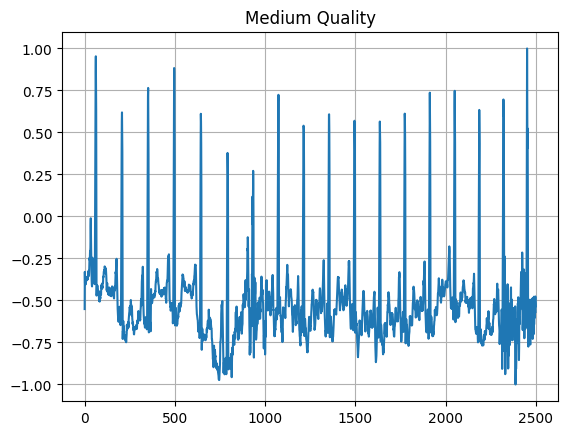

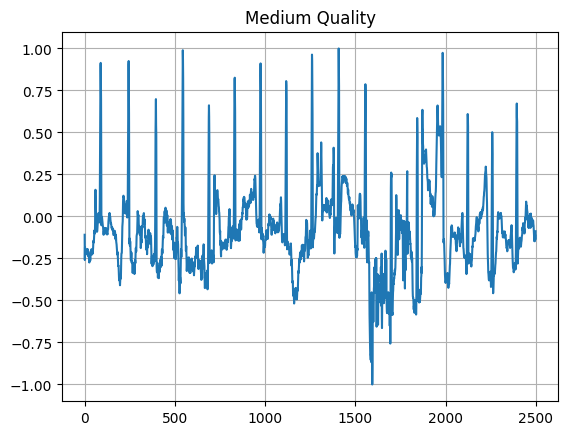

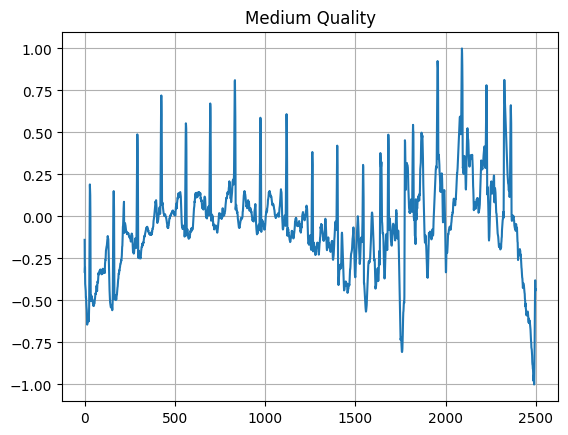

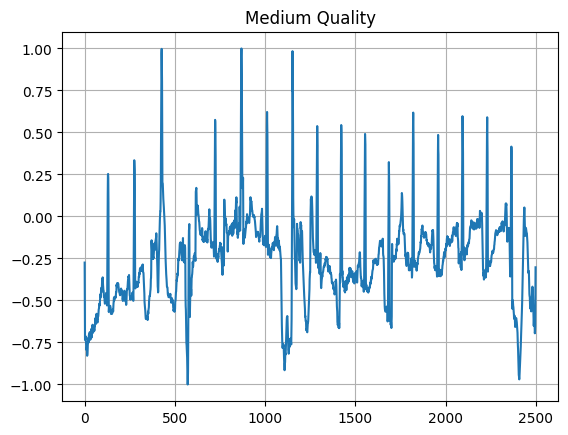

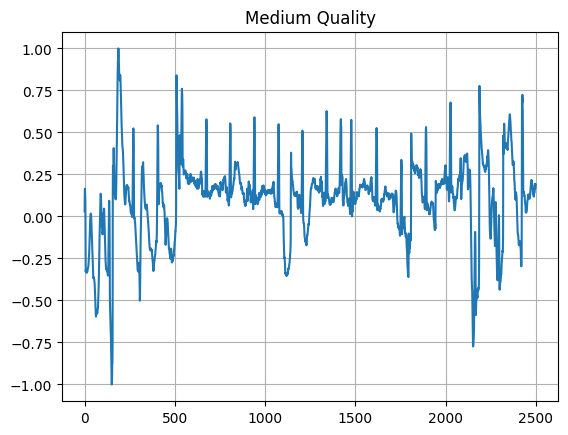

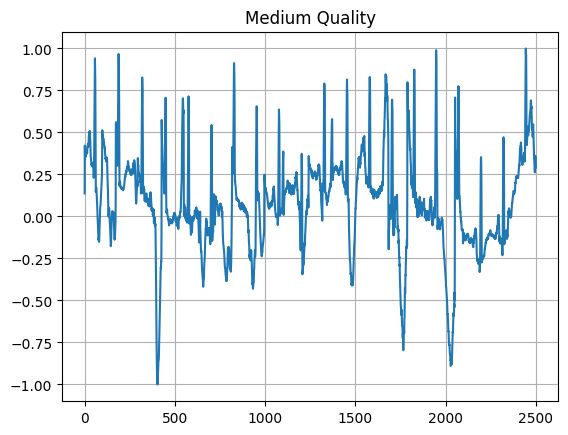

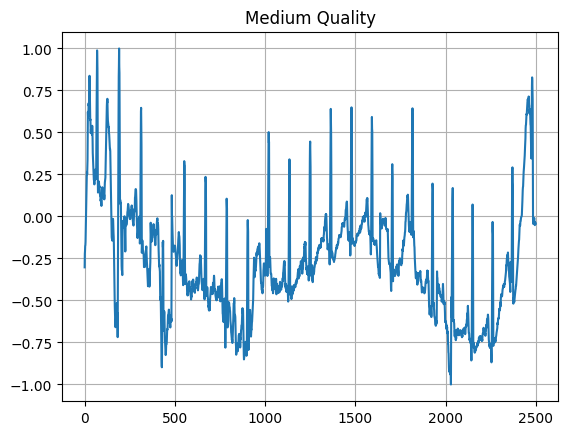

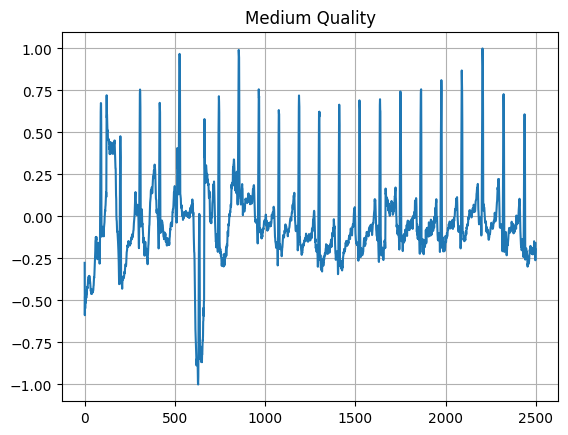

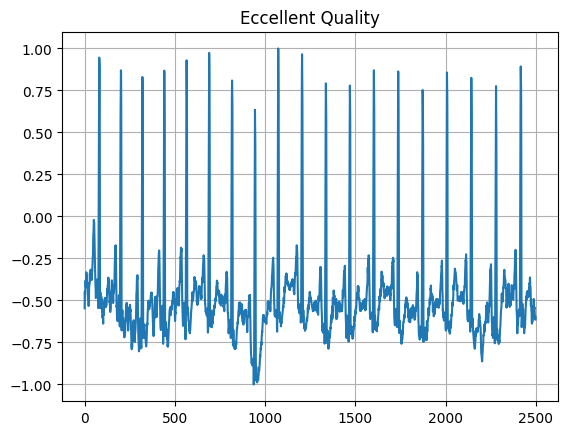

In [24]:
plot_first_n_samples(processed_dataset_path, 10)

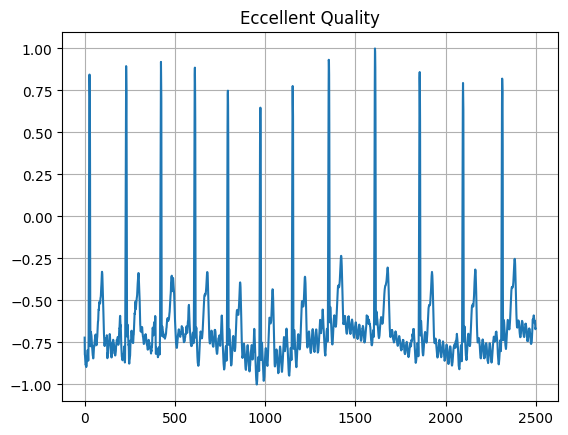

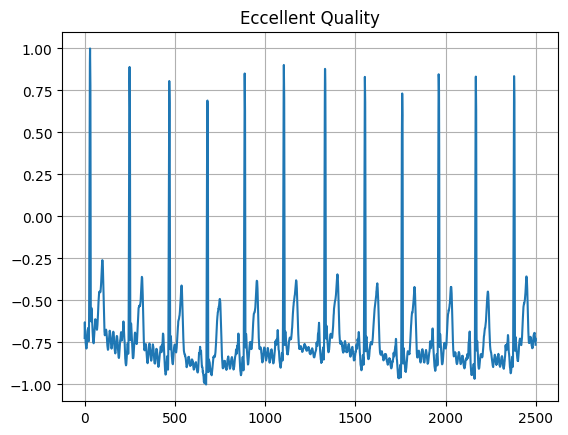

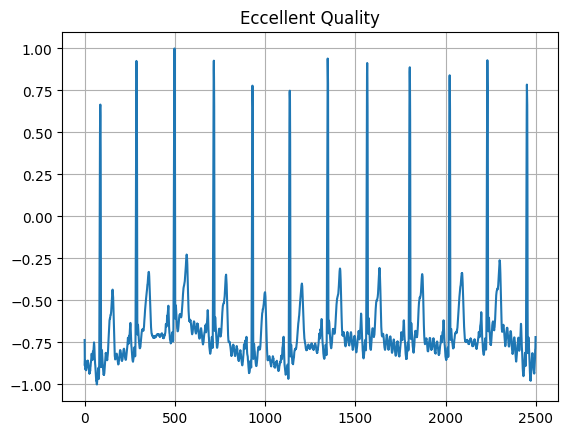

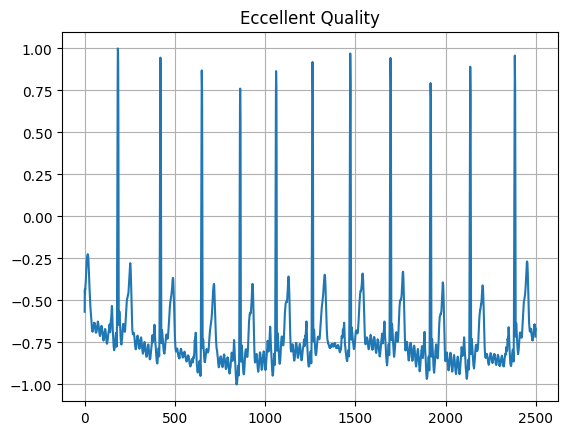

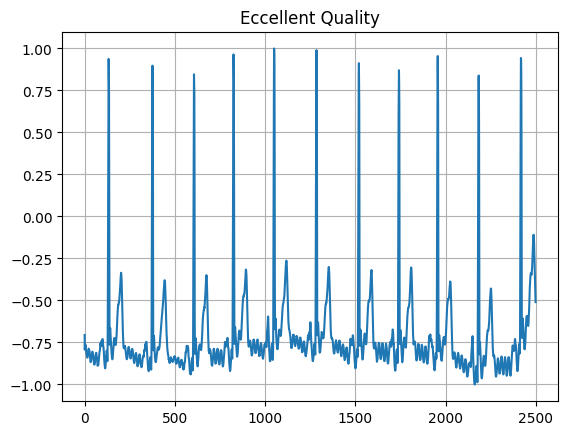

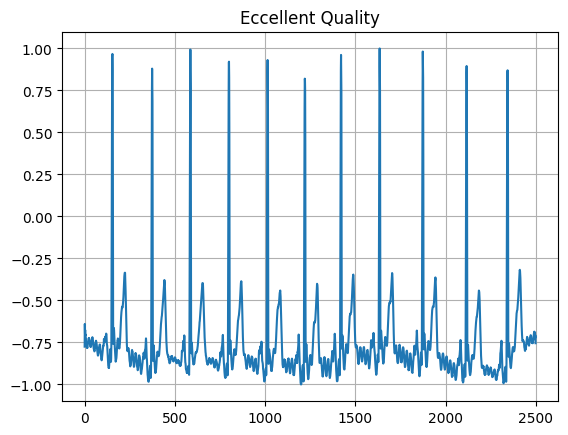

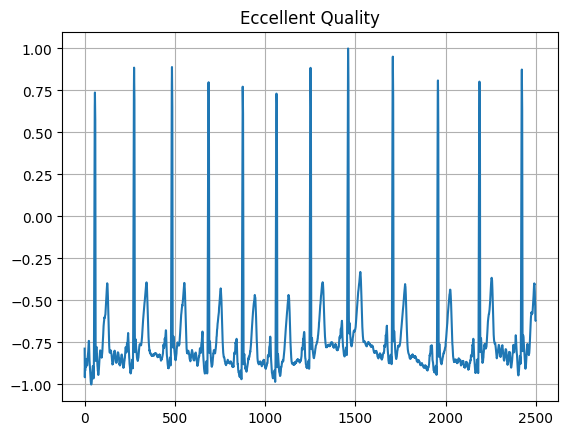

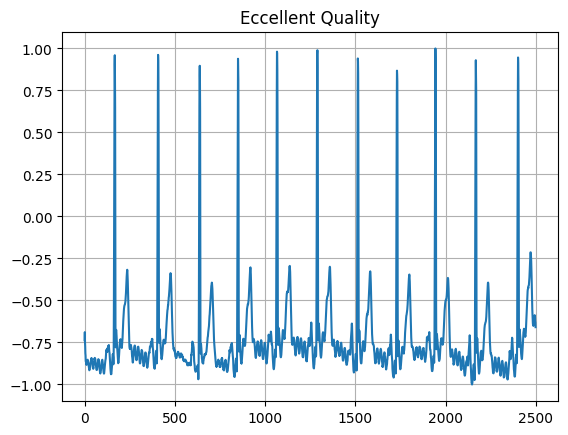

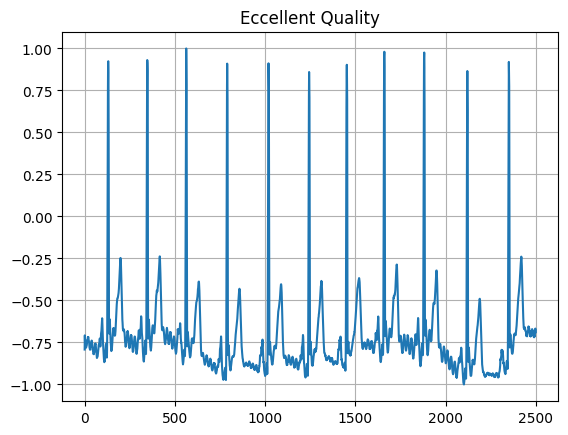

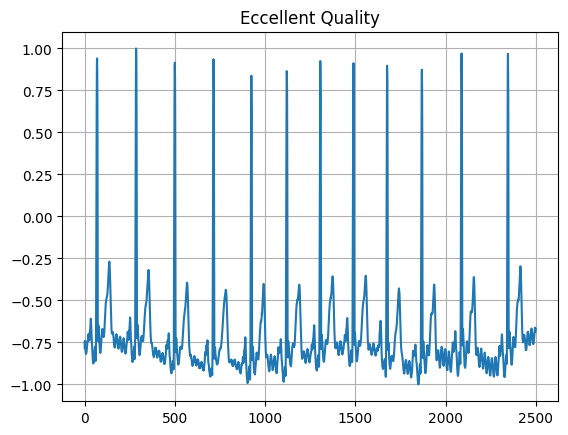

In [26]:
plot_samples_from_df(df, 1100, 1110)
#plot_samples_from_df(df, 100, 110)

In [27]:
# distribution for each class
print(class_distribution(df))

2500
1.0    17043
2.0    10628
3.0     5285
Name: count, dtype: int64
